In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
project_root = os.path.abspath("/Users/joschua/repos/harris_lab/hypnose/hypnose-analysis")
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import numpy as np 
import classification_utils
from classification_utils import *
from pathlib import Path
import harp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
from functools import reduce
from src.processing import detect_settings
import src.processing.detect_stage as detect_stage_module

%matplotlib widget

In [5]:
# Multi Date or SubjID Analysis. Can analyze all Sessions for given SubjID (run on subjid only), all SubjIDs for a date (run on date only), or specific SubjID(s) and Date(s) (run on lists of each)
# To analyze all subjids for a date, or vice versa, set the other argument to None

subjids = [32]
dates = [20251001]

multi_run_results = batch_analyze_sessions(subjids=subjids, dates=dates, save=True, verbose=False, print_summary=True)


[batch_analyze_sessions] Analyzing subject 32, date 20251001...
Detected stage: DoublesA_Stage5A
No hidden rule index found
Detected stage: DoublesA_Stage5A
No hidden rule index found
Detected stage: DoublesA_Stage5A
No hidden rule index found

SUMMARY: TRIAL CLASSIFICATION AND POKE TIME ANALYSIS FOR SUBJECT [32] DATE [20251001]

Sample offset time: 200.0 ms
Minimum sampling time: 200.0 ms
Response time window: 99999.00 s

TRIAL CLASSIFICATIONs:
Hidden Rule Location: Position None (index None)

Hidden Rule Odors: None

Total attempts: 111
-- Non-initiated sequences (total): 52 (46.8%)
    -- Position 1 attempts within trials 18 (34.6%)
    -- Baseline non-initiated sequences 34 (65.4%)
-- Initiated sequences (trials]): 59 (53.2%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 43 ( 72.9%)
   -- Hidden Rule trials (HR): 0 (0.0%)
   -- Hidden Rule Missed (HR_missed): 0 (0.0%)
-- Aborted sequences: 16 ( 27.1%)
   -- Aborted Hidden Rule trials (HR): 0 (0.0%)

REWARDED TRIALS BREAKDOW

In [21]:
res = analyze_session_multi_run_by_id_date(26, 20251002, verbose=False, print_summary=True, save=True)

Detected stage: HiddenRuleA_Location0
Hidden rule index: 0
Detected stage: HiddenRuleA_Location0
Hidden rule index: 0

SUMMARY: TRIAL CLASSIFICATION AND POKE TIME ANALYSIS FOR SUBJECT [26] DATE [20251002]

Sample offset time: 200.0 ms
Minimum sampling time: 350.0 ms
Response time window: 2 s

TRIAL CLASSIFICATIONs:
Hidden Rule Location: Position 1 (index 0)

Hidden Rule Odors: OdorC, OdorF

Total attempts: 263
-- Non-initiated sequences (total): 85 (32.3%)
    -- Position 1 attempts within trials 40 (47.1%)
    -- Baseline non-initiated sequences 45 (52.9%)
-- Initiated sequences (trials]): 178 (67.7%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 126 ( 70.8%)
   -- Hidden Rule trials (HR): 1 (0.8%)
   -- Hidden Rule Missed (HR_missed): 124 (98.4%)
-- Aborted sequences: 52 ( 29.2%)
   -- Aborted Hidden Rule trials (HR): 50 (96.2%)

REWARDED TRIALS BREAKDOWN:
-- Rewarded: 109 (86.5%)
-- Unrewarded: 1 (0.8%)
-- Reward Timeout: 16 (12.7%)

POKE TIME RANGES BY POSITION:
------------

In [25]:
# Loading experiments --> just define the SUBJID and DATE
root = load_experiment(26, 20251002, index=0) #can add index for multiple experiments; index=0 as default
stage = detect_stage_module.detect_stage(root)

Using subject directory: /Volumes/harris/hypnose/rawdata/sub-026_id-077
Loaded experiment 0: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-133_date-20251002/behav/2025-10-02T14-07-58
Detected stage: HiddenRuleA_Location0
Hidden rule index: 0


Using subject directory: /Volumes/harris/hypnose/rawdata/sub-026_id-077
Loaded experiment 0: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-132_date-20250929/behav/2025-09-29T11-24-11
Found 14 experiment files in /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-132_date-20250929/behav
Selected 14 experiment(s) for loading based on time window overlap.
Error processing event file ExperimentEvents_1904-01-03T19-00-00.csv: No columns to parse from file
No InitiationSequence events found
No EndInitiation events found
No AwaitReward events found
No Reset events found
No ChooseRandomSequence events found
No SampleRewardCondition events found
Experiment events loading complete! All events synchronized with load_all_streams timing.
Experiment events loading complete! All events synchronized with load_all_streams timing.
Experiment events loading complete! All events synchronized with load_all_streams timing.
Error processing event file ExperimentEvents_1904-01-03T20-00-00.csv: No columns

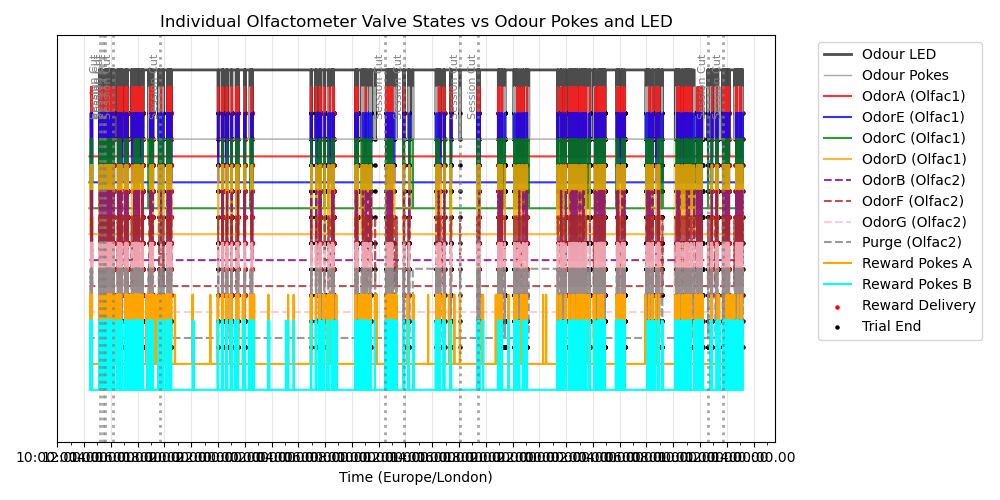

In [7]:
root = load_experiment(26, 20250929, index=0)
time_window = ('15:46:30', '15:47:30')
plot_valve_activity = plot_valve_and_poke_events(root=root, time_window=None)

In [3]:
data = load_all_streams(root)

Loading data streams from: /Volumes/harris/hypnose/rawdata/sub-020_id-072/ses-134_date-20250930/behav/2025-09-30T15-26-28
Loaded heartbeat data
Calculated real-time offset: 44464 days, 17:11:25
Created timestamp interpolation mapping
Loaded digital_input_data
Loaded output_set
Loaded output_clear
Loaded olfactometer_valves_0
Loaded olfactometer_valves_1
Loaded olfactometer_end_0
Loaded analog_data
Loaded flow_meter
Loaded video_data
Loaded pulse_supply_1
Loaded pulse_supply_2
Created odour_led

Applying time corrections to all data streams...
Applied correction to digital_input_data
Applied correction to output_set
Applied correction to output_clear
Applied correction to olfactometer_valves_0
Applied correction to olfactometer_valves_1
Applied correction to olfactometer_end_0
Applied correction to analog_data
Applied correction to flow_meter
Applied correction to video_data
Applied correction to odour_led

Data loading complete! Loaded 17 streams successfully.


In [4]:
events = load_experiment_events(root)

Loading experiment events...
Loaded heartbeat data for timing synchronization
Calculated real-time offset: 44464 days, 17:11:25
Created timestamp interpolation mapping
Found 2 experiment event files
Processing event file: ExperimentEvents_1904-01-04T23-00-00.csv with 117 rows
Using Seconds column with interpolation
Applied real-time offset: 44464 days, 17:11:25
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence' nan]
Found 22 EndInitiation events
Found 21 InitiationSequence events
Found 21 Reset events
Found 10 AwaitReward events
Found 21 SampleRewardCondition events
Found 21 ChooseRandomSequence events
Error processing event file ._ExperimentEvents_1904-01-04T23-00-00.csv: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte
Combined 21 InitiationSequence events
Combined 22 EndInitiation events
Combined 10 AwaitReward events
Combined 21 Reset events
Combined 21 ChooseRandomSequen

In [5]:
odor_map = load_odor_mapping(root, data=data, verbose=True)
print("Data streams loaded:", list(data.keys()))
print("Event types loaded:", list(events.keys()))
print("Odor mapping:", odor_map['odour_to_olfactometer_map'])

Loading odor mapping from session settings...
Loaded session settings
Found 10 valve configurations for olfactometer 0
Found 10 valve configurations for olfactometer 1
Created valve-to-command mapping: {'00': 3, '01': 7, '02': 5, '03': 6, '10': 4, '11': 8, '12': 9, '13': 2}
Created odor mapping: [['OdorA', 'OdorE', 'OdorC', 'OdorD'], ['OdorB', 'OdorF', 'OdorG', 'Purge']]
Odor mapping loaded successfully
Data streams loaded: ['heartbeat', 'real_time_offset', 'timestamp_to_time', 'interpolate_time', 'digital_input_data', 'output_set', 'output_clear', 'olfactometer_valves_0', 'olfactometer_valves_1', 'olfactometer_end_0', 'analog_data', 'flow_meter', 'video_reader', 'video_data', 'pulse_supply_1', 'pulse_supply_2', 'odour_led', 'behavior_reader', 'olfactometer_reader']
Event types loaded: ['combined_initiation_sequence_df', 'combined_end_initiation_df', 'combined_await_reward_df', 'combined_reset_df', 'combined_choose_random_sequence_df', 'combined_sample_reward_condition_df']
Odor mappin

In [6]:
trial_counts = detect_trials(data, events, root, verbose=True)

TRIAL DETECTION
Parameters: minimum_sampling_time=200.0ms, sample_offset_time=200.0ms

InitiationSequence 0: 2025-09-30 16:26:45.921984
  Found 8 poke periods
    Starting attempt 1 at 2025-09-30 16:26:47.291168
      Poke 1: 689.2ms (total: 689.2ms)
      SUCCESS: 689.2ms continuous poke (≥200.0ms)

InitiationSequence 1: 2025-09-30 16:26:55.220000
  Found 11 poke periods
    Starting attempt 1 at 2025-09-30 16:26:56.994720
      Poke 1: 721.6ms (total: 721.6ms)
      SUCCESS: 721.6ms continuous poke (≥200.0ms)

InitiationSequence 2: 2025-09-30 16:27:05.802976
  Found 8 poke periods
    Starting attempt 1 at 2025-09-30 16:27:16.692320
      Poke 1: 537.6ms (total: 537.6ms)
      SUCCESS: 537.6ms continuous poke (≥200.0ms)

InitiationSequence 3: 2025-09-30 16:27:24.572000
  Found 6 poke periods
    Starting attempt 1 at 2025-09-30 16:27:33.186784
      Poke 1: 60.1ms (total: 60.1ms)
      Gap to poke 2: 1211.2ms (≥200.0ms - sequence ends)
      FAILED: 60.1ms continuous poke (<200.0ms)


In [10]:
trial_outcomes_complete = classify_and_analyze_with_response_times(data, events, trial_counts, odor_map, stage, root)

CLASSIFYING TRIAL OUTCOMES WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS
Sample offset time: 200.0 ms
Minimum sampling time: 200.0 ms
Response time window: 2.0 s
Hidden rule location extracted: Location0 (index 0, position 1)
Found 869 total valve activations (excluding Purge)
Analyzing 196 initiated trials...
Found 154 AwaitReward events
Found 144 total supply port activities
Hidden Rule Odors inferred: ['OdorA', 'OdorB']

TRIAL CLASSIFICATION RESULTS WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS:
Hidden Rule Location: Position 1 (index 0)

Hidden Rule Odors: OdorA, OdorB

Total attempts: 276
-- Non-initiated sequences (total): 80 (29.0%)
    -- Position 1 attempts within trials 21 (26.2%)
    -- Baseline non-initiated sequences 59 (73.8%)
-- Initiated sequences (trials): 196 (71.0%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 154 (78.6%)
   -- Hidden Rule trials (HR): 12 (6.1%)
   -- Hidden Rule Missed (HR_missed): 3 (1.5%)
-- Aborted sequences: 42 (21.4%)
   -- Aborted Hidd

# Miscellaneous 

In [ ]:
cls = res['classification']
# Code like this can be used to extract data from res. This will display all trials with < threshold poke times in completed sequences
comp = cls["completed_sequences_with_response_times"]
pos_pokes_all = build_position_pokes_table(cls)
short_pokes = build_position_pokes_table(cls, threshold_ms=200)
display(short_pokes) 

In [21]:
# Find X s window with the most rewarded trials - used to find video segments

def find_peak_rewarded_window(res, window_sec=40):
    # Get rewarded trials table
    cls = res.get("classification", res)
    df = cls.get("completed_sequence_rewarded", pd.DataFrame())
    if df.empty:
        print("No rewarded trials found.")
        return None

    # Use valve_open_ts as trial time (or poke_first_in if you prefer)
    times = pd.to_datetime(df["sequence_start"], errors="coerce")
    df = df.assign(trial_time=times)
    df = df.dropna(subset=["trial_time"]).sort_values("trial_time").reset_index(drop=True)

    # Find the window with the most rewarded trials
    best_count = 0
    best_start = None
    best_end = None
    best_indices = []

    trial_times = df["trial_time"].values
    n = len(trial_times)
    for i in range(n):
        start = trial_times[i]
        end = start + np.timedelta64(window_sec, "s")
        # Find all trials within [start, end)
        mask = (trial_times >= start) & (trial_times < end)
        count = mask.sum()
        if count > best_count:
            best_count = count
            best_start = start
            best_end = end
            best_indices = np.where(mask)[0]

    print(f"Max rewarded trials in any {window_sec}s window: {best_count}")
    print(f"Window: {best_start} to {best_end}")
    # Optionally display the trials in that window
    display(df.iloc[best_indices])
    return df.iloc[best_indices]

# Example usage:
peak_trials = find_peak_rewarded_window(res, window_sec=40)

Max rewarded trials in any 40s window: 3
Window: 2025-09-08T13:56:21.521888000 to 2025-09-08T13:57:01.521888000


,initiation_sequence_time,sequence_start,sequence_end,continuous_poke_time_ms,trial_id,attempt_number,timestamp,odor_sequence,num_odors,last_odor,...,hit_hidden_rule,await_reward_time,first_supply_time,first_supply_port,first_supply_odor_identity,supply1_count,supply2_count,total_supply_count,run_id,trial_time
0,2025-09-08 13:56:20.396000,2025-09-08 13:56:21.521888,2025-09-08 13:56:29.252992,303.456,1,1,2025-09-08 13:56:21.521888,"[OdorE, OdorD, OdorC, OdorF, OdorB]",5,OdorB,...,False,2025-09-08 13:56:26.602976,2025-09-08 13:56:27.742496,2,B,0,1,1,1,2025-09-08 13:56:21.521888
1,2025-09-08 13:56:29.252992,2025-09-08 13:56:37.138528,2025-09-08 13:56:44.724992,447.904,2,1,2025-09-08 13:56:37.138528,"[OdorD, OdorC, OdorF, OdorG, OdorA]",5,OdorA,...,False,2025-09-08 13:56:41.945984,2025-09-08 13:56:43.218496,1,A,1,0,1,1,2025-09-08 13:56:37.138528
2,2025-09-08 13:56:44.724992,2025-09-08 13:56:53.244800,2025-09-08 13:57:01.756096,221.408,3,1,2025-09-08 13:56:53.244800,"[OdorE, OdorG, OdorD, OdorC, OdorA]",5,OdorA,...,False,2025-09-08 13:56:58.558976,2025-09-08 13:57:00.239488,1,A,1,0,1,1,2025-09-08 13:56:53.244800


In [3]:
# Cutting video segments around start and end times. E.g., used to get video around peak rewarded trials identified above. 
# Automatically finds correct file, but runs faster if index is specified
# specify 30 or 60 fps (fps mismatch visible if video duration is not matching input duration)
start_time = "15:46:54"
end_time = "15:47:04"
cut_video(26, 20251002, start_time, end_time, fps=60)

OpenCV: Couldn't read video stream from file "/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-133_date-20251002/behav/2025-10-02T14-42-31/VideoData/._VideoData_1904-01-06T22-00-00.avi"


Successfully read 600 frames from /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-133_date-20251002/behav/2025-10-02T14-42-31/VideoData/VideoData_1904-01-06T22-00-00.avi
MoviePy - Building video /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-133_date-20251002/video_analysis/video_cut_15-46-54-000000_15-47-04-000000.mp4.
MoviePy - Writing video /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-133_date-20251002/video_analysis/video_cut_15-46-54-000000_15-47-04-000000.mp4



MoviePy - Done !
MoviePy - video ready /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-133_date-20251002/video_analysis/video_cut_15-46-54-000000_15-47-04-000000.mp4
Saved cut video to: /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-133_date-20251002/video_analysis/video_cut_15-46-54-000000_15-47-04-000000.mp4


PosixPath('/Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-133_date-20251002/video_analysis/video_cut_15-46-54-000000_15-47-04-000000.mp4')

# Testing of new functions

# Debugging Functions:



In [48]:
# Quick code to look for brief purge events in between odors in completed trials

import pandas as pd
import numpy as np
import re
from bisect import bisect_left, bisect_right

def list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=50.0, verbose=True):
    """
    Find Purge events shorter than threshold_ms that occur between distinct odor presentations
    in completed trials. A Purge onset is counted if it lies within:
       [current_odor_end - onset_slack_ms, next_odor_start + onset_slack_ms]
    Returns a list of dicts (one per event) and prints a summary.
    """

    # --- Helpers to resolve Purge columns ---
    def _ci_get(d, key):
        if not isinstance(d, dict):
            return None
        lk = str(key).lower()
        for k, v in d.items():
            if str(k).lower() == lk:
                return v
        return None

    def _col_to_idx(col, row_len=None):
        if isinstance(col, (int, np.integer)):
            idx_num = int(col)
        else:
            m = re.search(r'(\d+)', str(col))
            if not m:
                return None
            idx_num = int(m.group(1))
        if row_len is None:
            return idx_num
        if 0 <= idx_num < row_len:
            return idx_num
        if 1 <= idx_num <= row_len:
            return idx_num - 1
        return None

    def _resolve_odor_name(odor_map, olf_id, idx, col=None):
        v2o = odor_map.get("valve_to_odor", {})
        if isinstance(v2o, dict):
            name = v2o.get((olf_id, idx))
            if name is None and col is not None:
                name = v2o.get(col)
            if name is None:
                name = v2o.get(idx)
            if isinstance(name, str):
                return name
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        if isinstance(grid, (list, tuple)) and len(grid) > olf_id and isinstance(grid[olf_id], (list, tuple)):
            row = grid[olf_id]
            if 0 <= idx < len(row):
                return row[idx]
        return None

    def _purge_columns(odor_map):
        cols = []
        olf_valves = odor_map["olfactometer_valves"]
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        for olf_id, df in olf_valves.items():
            if df is None or getattr(df, "empty", True):
                continue
            row_len = len(grid[olf_id]) if isinstance(grid, (list, tuple)) and len(grid) > olf_id else None
            for col in df.columns:
                idx = _col_to_idx(col, row_len=row_len)
                if idx is None:
                    continue
                name = _resolve_odor_name(odor_map, olf_id, idx, col=col)
                if isinstance(name, str) and name.lower() == "purge":
                    cols.append((olf_id, idx, col))
        return cols

    def _purge_events(odor_map):
        """Return list of dicts: {start,end,duration_ms,olf_id,idx,col} across all purge columns."""
        evs = []
        for olf_id, idx, col in _purge_columns(odor_map):
            df = odor_map["olfactometer_valves"][olf_id]
            if df is None or getattr(df, "empty", True):
                continue
            s = df[col].astype(bool)
            rises = s & ~s.shift(1, fill_value=False)
            falls = ~s & s.shift(1, fill_value=False)
            starts = list(s.index[rises])
            ends = list(s.index[falls])
            i = j = 0
            while i < len(starts) and j < len(ends):
                if ends[j] <= starts[i]:
                    j += 1
                    continue
                dur_ms = (ends[j] - starts[i]).total_seconds() * 1000.0
                evs.append({
                    "start": starts[i],
                    "end": ends[j],
                    "duration_ms": dur_ms,
                    "olf_id": olf_id,
                    "idx": idx,
                    "col": col,
                })
                i += 1
                j += 1
        evs.sort(key=lambda e: e["start"])
        return evs

    # --- Build completed trials dataframe and inter-odor windows ---
    cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)
    completed_keys = [
        "completed_sequence_rewarded",
        "completed_sequence_unrewarded",
        "completed_sequence_reward_timeout",
    ]
    completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
    completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

    def _trial_id(row):
        for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
            if k in row and pd.notna(row[k]):
                return row[k]
        return row.name

    # Collect inter-odor windows per trial: [(trial_id, pos_i, pos_j, win_start, win_end)]
    windows = []
    for _, row in completed_df.iterrows():
        pov = row.get("position_valve_times")
        if not isinstance(pov, dict) or not pov:
            continue
        tid = _trial_id(row)
        # sort positions by position number
        positions = sorted([p for p in pov.keys() if isinstance(p, (int, np.integer))])
        # windows between consecutive positions
        for i in range(len(positions) - 1):
            p_i = positions[i]
            p_j = positions[i + 1]
            end_i = pov[p_i].get("valve_end")
            start_j = pov[p_j].get("valve_start")
            if pd.isna(end_i) or pd.isna(start_j) or end_i is None or start_j is None:
                continue
            if end_i >= start_j:
                # overlapping/invalid; skip
                continue
            win_start = end_i - pd.Timedelta(milliseconds=onset_slack_ms)
            win_end = start_j + pd.Timedelta(milliseconds=onset_slack_ms)
            windows.append((tid, p_i, p_j, win_start, win_end))

    # --- Scan purge events and match onsets within windows ---
    purge_events = _purge_events(odor_map)
    starts = [e["start"] for e in purge_events]

    matches = []
    for tid, p_i, p_j, ws, we in windows:
        lo = bisect_left(starts, ws)
        hi = bisect_right(starts, we)
        for k in range(lo, hi):
            e = purge_events[k]
            if e["duration_ms"] < threshold_ms:
                matches.append({
                    "trial_id": tid,
                    "from_pos": p_i,
                    "to_pos": p_j,
                    "start": e["start"],
                    "end": e["end"],
                    "duration_ms": e["duration_ms"],
                    "olf_id": e["olf_id"],
                    "col": e["col"],
                })

    # Summary/print
    if verbose:
        print(f"Short Purge events (< {threshold_ms} ms) between odors in completed trials "
              f"(onset slack ±{onset_slack_ms} ms): {len(matches)}")
        by_trial = {}
        for m in matches:
            by_trial.setdefault(m["trial_id"], 0)
            by_trial[m["trial_id"]] += 1
        if matches:
            for m in sorted(matches, key=lambda x: (x["trial_id"], x["start"])):
                print(f"- trial {m['trial_id']} pos {m['from_pos']}->{m['to_pos']}: "
                      f"{m['start'].isoformat()} -> {m['end'].isoformat()} "
                      f"({m['duration_ms']:.1f} ms)  olf {m['olf_id']} col '{m['col']}'")
            print("\nCounts by trial:")
            for tid in sorted(by_trial):
                print(f"  trial {tid}: {by_trial[tid]}")

    return matches

# Example usage:
matches = list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=100.0, verbose=True)
len(matches)

Short Purge events (< 200.0 ms) between odors in completed trials (onset slack ±100.0 ms): 113
- trial 4 pos 3->4: 2025-09-07T14:36:46.469536 -> 2025-09-07T14:36:46.605504 (136.0 ms)  olf 1 col 'Valve3'
- trial 5 pos 4->5: 2025-09-07T14:37:06.771488 -> 2025-09-07T14:37:06.870496 (99.0 ms)  olf 1 col 'Valve3'
- trial 6 pos 2->3: 2025-09-07T14:37:21.450496 -> 2025-09-07T14:37:21.620480 (170.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 2->3: 2025-09-07T14:38:24.026496 -> 2025-09-07T14:38:24.108480 (82.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 3->4: 2025-09-07T14:38:24.811520 -> 2025-09-07T14:38:24.934496 (123.0 ms)  olf 1 col 'Valve3'
- trial 9 pos 1->2: 2025-09-07T14:38:55.848480 -> 2025-09-07T14:38:55.997504 (149.0 ms)  olf 1 col 'Valve3'
- trial 11 pos 2->3: 2025-09-07T14:39:29.279488 -> 2025-09-07T14:39:29.375488 (96.0 ms)  olf 1 col 'Valve3'
- trial 13 pos 1->2: 2025-09-07T14:39:59.003488 -> 2025-09-07T14:39:59.202496 (199.0 ms)  olf 1 col 'Valve3'
- trial 14 pos 3->4: 2025-09-07T14:40:23.7

113

In [ ]:
# For a schema file, check any poke that is < threshold (e.g. 200 ms), within completed sequences
import pandas as pd
import json, ast
from pathlib import Path
from collections.abc import Mapping

def _parse_obj(x):
    if isinstance(x, (dict, list, tuple)):
        return x
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return None
        # Try JSON first, then Python literal
        try:
            return json.loads(s)
        except Exception:
            try:
                return ast.literal_eval(s)
            except Exception:
                return None
    return None

def _iter_pos_items(ppt):
    # Yield (position, info_dict) for dict/list
    if isinstance(ppt, Mapping):
        for k, v in ppt.items():
            if not isinstance(v, Mapping):
                try:
                    v = dict(v)
                except Exception:
                    continue
            pos = v.get("position")
            if pos is None:
                try:
                    pos = int(k)
                except Exception:
                    pos = k
            yield pos, v
    elif isinstance(ppt, (list, tuple)):
        for v in ppt:
            if isinstance(v, Mapping):
                yield v.get("position"), v

def _normalize_valves(pvt):
    # Normalize to dict: position -> valve dict
    out = {}
    if isinstance(pvt, Mapping):
        items = list(pvt.items())
    elif isinstance(pvt, (list, tuple)):
        items = [(v.get("position"), v) for v in pvt if isinstance(v, Mapping)]
    else:
        items = []
    for k, v in items:
        if not isinstance(v, Mapping):
            try:
                v = dict(v)
            except Exception:
                v = {}
        pos = v.get("position")
        if pos is None:
            try:
                pos = int(k)
            except Exception:
                pos = k
        out[pos] = v
    return out

def extract_short_pokes_from_saved(schema_path: str | Path, threshold_ms: float = 200.0) -> pd.DataFrame:
    schema_path = Path(schema_path)
    csv_path = schema_path.with_suffix("").with_suffix(".csv")  # replace .schema.json -> .csv
    if not csv_path.exists():
        # fallback: try sibling CSV with same stem
        csv_path = schema_path.parent / (schema_path.stem.replace(".schema", "") + ".csv")
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found next to schema: {csv_path}")

    df = pd.read_csv(csv_path)

    # Identify column names for per-position fields
    poke_col = None
    valve_col = None
    for c in df.columns:
        lc = c.lower()
        if poke_col is None and "position" in lc and "poke" in lc:
            poke_col = c
        if valve_col is None and "position" in lc and "valve" in lc:
            valve_col = c
    if poke_col is None:
        raise KeyError("Could not find position_poke_times column in CSV")
    if valve_col is None:
        # some outputs may not store per-position valves; still proceed
        valve_col = None

    rows = []
    for _, row in df.iterrows():
        ppt = _parse_obj(row.get(poke_col))
        if ppt is None:
            continue
        pvt_raw = _parse_obj(row.get(valve_col)) if valve_col else None
        valve_map = _normalize_valves(pvt_raw) if pvt_raw is not None else {}

        run_id = row.get("run_id")
        trial_id = row.get("trial_id")

        for pos, info in _iter_pos_items(ppt):
            if not isinstance(info, Mapping):
                try:
                    info = dict(info)
                except Exception:
                    continue
            poke_ms = pd.to_numeric(info.get("poke_time_ms"), errors="coerce")
            if pd.isna(poke_ms) or poke_ms <= 0 or poke_ms >= threshold_ms:
                continue

            # normalize pos
            try:
                pos_norm = int(pos) if pos is not None else None
            except Exception:
                pos_norm = pos

            vt = valve_map.get(pos_norm, {})
            odor = info.get("odor_name") or (vt or {}).get("odor_name")
            first_in = info.get("poke_first_in")
            valve_open = (vt or {}).get("valve_open_ts")
            valve_close = (vt or {}).get("valve_close_ts")
            event_ts = first_in if first_in is not None else valve_open  # measurement start

            rows.append({
                "run_id": run_id,
                "trial_id": trial_id,
                "position": pos_norm,
                "odor": odor,
                "poke_ms": float(poke_ms),
                "event_ts": event_ts,
                "valve_open_ts": valve_open,
                "valve_close_ts": valve_close,
                "poke_first_in": first_in,
            })

    out = pd.DataFrame(rows)
    if not out.empty:
        out["event_ts"] = pd.to_datetime(out["event_ts"], errors="coerce")
        out = out.sort_values(["run_id","trial_id","position","event_ts"], kind="stable", na_position="last").reset_index(drop=True)
    return out

# Use your saved path
schema_path = "/Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-122_date-20250909/saved_analysis_results/completed_sequences_with_response_times.schema.json"
short_pokes = extract_short_pokes_from_saved(schema_path, threshold_ms=200.0)
display(short_pokes)
print(f"{len(short_pokes)} positions with poke_time_ms < 200 ms")

In [11]:
# Identify trial IDs for trials with poke time bewlow threshold 
threshold_ms = 200.0

# Get the classification DataFrames
cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)

completed_keys = [
    "completed_sequence_rewarded",
    "completed_sequence_unrewarded",
    "completed_sequence_reward_timeout",
]
completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

def _trial_id(row):
    for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
        if k in row and pd.notna(row[k]):
            return row[k]
    return row.name  # fallback

hits = []
for _, row in completed_df.iterrows():
    pos_pokes = row.get("position_poke_times")
    if not isinstance(pos_pokes, dict):
        continue
    tid = _trial_id(row)
    for pos, info in pos_pokes.items():
        if not isinstance(info, dict):
            continue
        ms = info.get("poke_time_ms")
        if ms is None:
            continue
        if ms < threshold_ms:
            odor = info.get("odor_name")
            hits.append((ms, tid, pos, odor))

# Print results sorted by poke time
if not hits:
    print(f"No completed-trial positions with poke_time_ms < {threshold_ms} ms found.")
else:
    hits.sort(key=lambda x: x[0])
    print(f"Trials with poke_time_ms < {threshold_ms} ms (n={len(hits)}):")
    for ms, tid, pos, odor in hits:
        print(f"- trial {tid}, position {pos}, {odor}: {ms:.1f} ms")

Trials with poke_time_ms < 200.0 ms (n=11):
- trial 163, position 1, OdorF: 56.8 ms
- trial 107, position 1, OdorG: 100.1 ms
- trial 153, position 2, OdorC: 117.1 ms
- trial 161, position 3, OdorC: 155.9 ms
- trial 51, position 2, OdorE: 171.5 ms
- trial 130, position 2, OdorG: 187.9 ms
- trial 178, position 3, OdorD: 194.8 ms
- trial 179, position 2, OdorF: 197.9 ms
- trial 168, position 1, OdorG: 199.0 ms
- trial 181, position 1, OdorD: 199.8 ms
- trial 11, position 2, OdorE: 199.9 ms
